In [1]:
import re
import os
import unicodedata as uni
from pickle import load, dump

import pandas as pd
import numpy as np
import missingno

## Mengumpulkan hasil unduhan

In [2]:
total = []
for root, _, files in os.walk('collected_infobox'):
    for file in files:
        with open(os.sep.join([root, file]), 'rb') as f:
            total.extend(load(f))

In [3]:
total = pd.DataFrame(total)
print(sorted([x for x in total]))

['Fakultas', 'File', 'Jenis Koleksi', 'Kata Kunci', 'Kontributor / Dosen Pembimbing', 'Penerbit', 'Staf Input/Edit', 'Subjek', 'Sumber', 'Tanggal Input', 'abstrak', 'file', 'id', 'oleh', 'title']


Ubah nama kolom ke bentuk yang memudahkan proses perapian

In [4]:
total.rename(columns={'Kontributor / Dosen Pembimbing':'kontributor',
                      'Jenis Koleksi':'koleksi',
                      'Penerbit':'penerbit',
                      'Fakultas':'fakultas',
                      'Sumber': 'sumber',
                      'Subjek': 'subjek',
                      'Kata Kunci':'keyword',
                      'Tanggal Input':'tanggal',
                      'Staf Input/Edit':'staf'},
             inplace=True)
print(sorted([x for x in total]))

['File', 'abstrak', 'fakultas', 'file', 'id', 'keyword', 'koleksi', 'kontributor', 'oleh', 'penerbit', 'staf', 'subjek', 'sumber', 'tanggal', 'title']


Saya memutuskan kolom `File` dan `staf` tidak relevan ketika membuat situs pencarian.

In [5]:
total.drop(columns=['File', 'staf'], inplace=True)
print(sorted([x for x in total]))

['abstrak', 'fakultas', 'file', 'id', 'keyword', 'koleksi', 'kontributor', 'oleh', 'penerbit', 'subjek', 'sumber', 'tanggal', 'title']


# Analisis dan merapikan data per kolom

## fakultas

In [6]:
sorted(set(total['fakultas']))

['',
 'Fakultas Ilmu dan Teknologi Kebumian (FITB)',
 'Fakultas Matematika dan Ilmu Pengetahuan Alam (FMIPA)',
 'Fakultas Seni Rupa dan Desain (FSRD)',
 'Fakultas Teknik Mesin dan Dirgantara (FTMD)',
 'Fakultas Teknik Pertambangan dan Perminyakan (FTTM)',
 'Fakultas Teknik Sipil dan Lingkungan (FTSL)',
 'Fakultas Teknologi Industri (FTI)',
 'Sekolah Arsitektur, Perencanaan dan Pengembangan Kebijakan (SAPPK)',
 'Sekolah Bisnis dan Manajemen (SBM)',
 'Sekolah Farmasi (SF)',
 'Sekolah Ilmu dan Teknologi Hayati (SITH)',
 'Sekolah Teknik Elektro dan Informatika (STEI)']

Di akhir proses, saya akan mengunggah data ini ke sebuah database. Untuk itu saya memutuskan untuk memperkecil memori databse dengan hanya menyimpan akronim dari setiap fakultas.

In [7]:
f = lambda val: val.split('(')[1][:-1] if val else ''
total['fakultas'] = total['fakultas'].apply(f)
print(sorted(set(total['fakultas'])))

['', 'FITB', 'FMIPA', 'FSRD', 'FTI', 'FTMD', 'FTSL', 'FTTM', 'SAPPK', 'SBM', 'SF', 'SITH', 'STEI']


## penerbit

Mari kita lihat berapa banyak data unik di kolom ini

In [8]:
#sorted(set(total['penerbit']))

penerbit sebagian besar merupakan gabungan nama fakultas dan nama prodi. Sebaiknya kita memisahkan kedua data ini, dan menggunakan data fakultas yang didapat untuk mengisi beberapa baris data di kolom `fakultas` yang kosong. 

In [9]:
def extract(penerbit):
    if '-' not in penerbit:
        return ('', penerbit)
    elif penerbit == 'FTTM - Teknik Metalurgi - S1':
        # outlier?
        return ('FTTM', 'Teknik Metalurgi - S1')
    else:
        # coba untuk pisahkan nama fakultas dan nama prodi
        fakultas, *prodi = sorted(penerbit.split('-'), key=len)
        if fakultas.istitle():
            # penerbit tidak mengandung nama fakultas
            return ('', penerbit)
        return (fakultas.strip(), prodi[0].strip())

In [10]:
tmp = total.penerbit.apply(extract)
tmp = pd.DataFrame({'fakultas':x, 'prodi':y} for x,y in tmp)
tmp

,fakultas,prodi
0,,
1,,
2,FTI,Teknik Fisika
3,,
4,FTSL,Teknik Sipil
...,...,...
57401,SAPPK,Arsitektur
57402,FTI,Logistik
57403,FITB,Teknik Geodesi dan Geomatika
57404,,Teknik Sipil


In [11]:
for x, y in zip(total['fakultas'], tmp['fakultas']):
    if x and y and x!=y: print(x, y)
else:
    print("both columns can be merged")

both columns can be merged


In [12]:
fakultas = []
for x, y in zip(total['fakultas'], tmp['fakultas']):
    if x: fakultas.append(x)
    else: fakultas.append(y)

Terapkan perubahan ke dataframe

In [13]:
total['fakultas'] = pd.Series(fakultas)
print(sorted(set(total['fakultas'])))

['', 'FITB', 'FMIPA', 'FSRD', 'FTI', 'FTMD', 'FTSL', 'FTTM', 'SAPPK', 'SBM', 'SF', 'SITH', 'STEI']


In [14]:
total['penerbit'] = tmp['prodi']
print(sorted(set(total['penerbit'])))

['', 'Administrasi Bisnis', 'Aktuaria', 'Arsitektur', 'Arsitektur Lanskap', 'Astronomi', 'Biologi', 'Biomanajemen', 'Bioteknologi', 'Desain', 'Desain Interior', 'Desain Komunikasi Visual', 'Desain Produk', 'Farmasi', 'Farmasi Industri', 'Farmasi Klinik dan Masyarakat', 'Fisika', 'Geofisaka Terapan', 'Ilmu Seni Rupa dan Desain', 'Ilmu dan Teknik Material', 'Informatika', 'Instrumentasi dan Kontrol', 'Keolahragaan', 'Kewirausahaan', 'Kimia', 'Kriya', 'Lain-lain', 'Logistik', 'Magister Bisnis dan Administrasi - Teknologi', 'Manajemen Rekayasa Industri', 'Matematika', 'Meteorologi', 'Mikrobiologi', 'Oseanografi', 'Pengajaran Fisika', 'Pengajaran Kimia', 'Pengajaran Matematika', 'Pengelolaan Infrastruktur Air Bersih dan Sanitasi', 'Pengelolaan Sumberdaya Air', 'Perencanaan Wilayah dan Kota', 'Rancang Kota', 'Rekayasa  Infrastruktur Lingkungan', 'Rekayasa Hayati', 'Rekayasa Kehutanan', 'Rekayasa Nuklir', 'Rekayasa Pertambangan', 'Rekayasa Pertanian', 'Rekayasa Struktur', 'Sains Kebumian', 'S

Saya memutuskan untuk tidak memperbaiki kesalahan penamaan penerbit, karena saya tidak mengetahui sumber yang dapat saya jadikan acuan penilaian.

## koleksi

In [15]:
sorted(set(total['koleksi']))

['Anggota',
 'Buku',
 'Buku elektronik',
 'Direktori Pakar',
 'Jurnal elektronik',
 'Kliping Elektronik',
 'Koleksi Buku Langka',
 'Laporan Penelitian',
 'Literatur Kelabu',
 'Organisasi',
 'Peraturan hukum',
 'Prosiding',
 'S1-Tugas Akhir',
 'S2 - Tesis',
 'S3-Disertasi']

Di bagian ini saya memilih untuk mengubah nama tiga jenis koleksi. Menurut saya pribadi, dalam proses pencarian data, hasil terhadap kueri `Skripsi` akan lebih baik ketimbang `Tugas Akhir`. Tentu, hal ini pada akhirnya tergantung jenis database dan metode pencarian yang digunakan.

In [16]:
mapping = {'S1-Tugas Akhir':'Skripsi',
           'S2 - Tesis':'Tesis',
           'S3-Disertasi':'Disertasi'}

f = lambda val: mapping[val] if val in mapping else val.title() 
total['koleksi'] = total['koleksi'].apply(f)
print(sorted(set(total['koleksi'])))

['Anggota', 'Buku', 'Buku Elektronik', 'Direktori Pakar', 'Disertasi', 'Jurnal Elektronik', 'Kliping Elektronik', 'Koleksi Buku Langka', 'Laporan Penelitian', 'Literatur Kelabu', 'Organisasi', 'Peraturan Hukum', 'Prosiding', 'Skripsi', 'Tesis']


## Interlude: merapikan karakter
Sejak tahap ini, kita akan berurusan dengan kolom-kolom yang berisi teks bebas, yang dapat berisi banyak keanehan dan kesalahan format. Saya mengawali proses ini dengan memetakan setiap karakter teks bebas ke representasi yang lebih mudah untuk saya akses.

In [17]:
charset = set()

for col in ['abstrak', 'keyword', 'kontributor', 'oleh', 'title', 'sumber', 'subjek']:
    wordlist = set(total[col])
    charlist = set(''.join(wordlist))
    charset.update(charlist)
    
print(sorted(charset))
# sure... handling UTF-8 data is a mess. BDSM++.

['\t', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '\x81', '\x84', '\x85', '\x87', '\x8d', '\x8f', '\x92', '\x94', '\x9d', '\xa0', '¡', '¢', '£', '¤', '¥', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Ç', 'È', 'É', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ó', 'ô', 'õ', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'ā',

In [18]:
# let normalize using NFKC normal form. in simple term
# it means changing chars to more ASCII like chars
# ¾ as 3/4, 𝐍 as N, etc...

# handle special case earlier
mapping = {'\t': ' ', # tab
           '\n': '\n', # "variations" of newline
           '\r': '\n', #
           '\u2028': '\n',
           '\u2029': '\n',
           '\u200b': '', # zero width chars... why?
           '\u2061': '',
           '\xad':'',
           '\ufeff':'', # i wonder from where this come from...
          }

charset = charset - set(mapping.keys())

def normalize(char):
    # check if char has definition in UCD
    try: uni.name(char)
    # for now... just remove it
    except: return ''
    return uni.normalize('NFKC', char)

for c in charset:
    mapping[c] = normalize(c)

print([mapping[c] for c in sorted(charset)]) 

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '', '', '', '', '', '', '', '', '', '', ' ', '¡', '¢', '£', '¤', '¥', '§', ' ̈', '©', 'a', '«', '¬', '®', ' ̄', '°', '±', '2', '3', ' ́', 'μ', '¶', '·', ' ̧', '1', 'o', '»', '1⁄4', '1⁄2', '3⁄4', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Ç', 'È', 'É', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ó', 'ô', 'õ', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'ā', 'ć', 'Č', 'č', 'Ē', 'ē', 'ğ', 'Ĥ', 'İ', 'ł', 'ń', 'Ŋ', 'ŋ'

Lakukan perapian

In [19]:
pattern = '|'.join(sorted(re.escape(c) for c in mapping))

In [20]:
normalize = lambda text: re.sub(pattern, lambda m: mapping.get(m.group(0)), text, flags=re.IGNORECASE)
multi_space = lambda x: re.sub(' ( )+', ' ', x)
under4word = lambda text: '' if len(text)<4 else text

In [21]:
%%time

for col in ['abstrak', 'title', 'keyword', 'oleh', 'kontributor', 'sumber', 'subjek']:
    if col!='abstrak':
        # ada baiknya membiarkan newline pada abstrak
        # namun untuk kolom selain abstrak...
        total[col] = total[col].apply(lambda x: x.replace('\n',' '))
    
    total[col] = total[col].apply(normalize)
    total[col] = total[col].apply(multi_space).apply(str.strip)
    total[col] = total[col].apply(under4word)

CPU times: user 2min 29s, sys: 147 ms, total: 2min 30s
Wall time: 2min 30s


## subjek

Mari kita lihat berapa banyak data unik, dan berapa persen data non-NA kolom ini

In [22]:
len(set(total['subjek'])), 100*len(total[total['subjek']!=''])/len(total)

(124, 13.080514231961816)

Hanya 13%. Saya ingin melihat bagaimana sebaran data ini di dataframe, relatif terhadap sebaran data NA kolom-kolom lain.

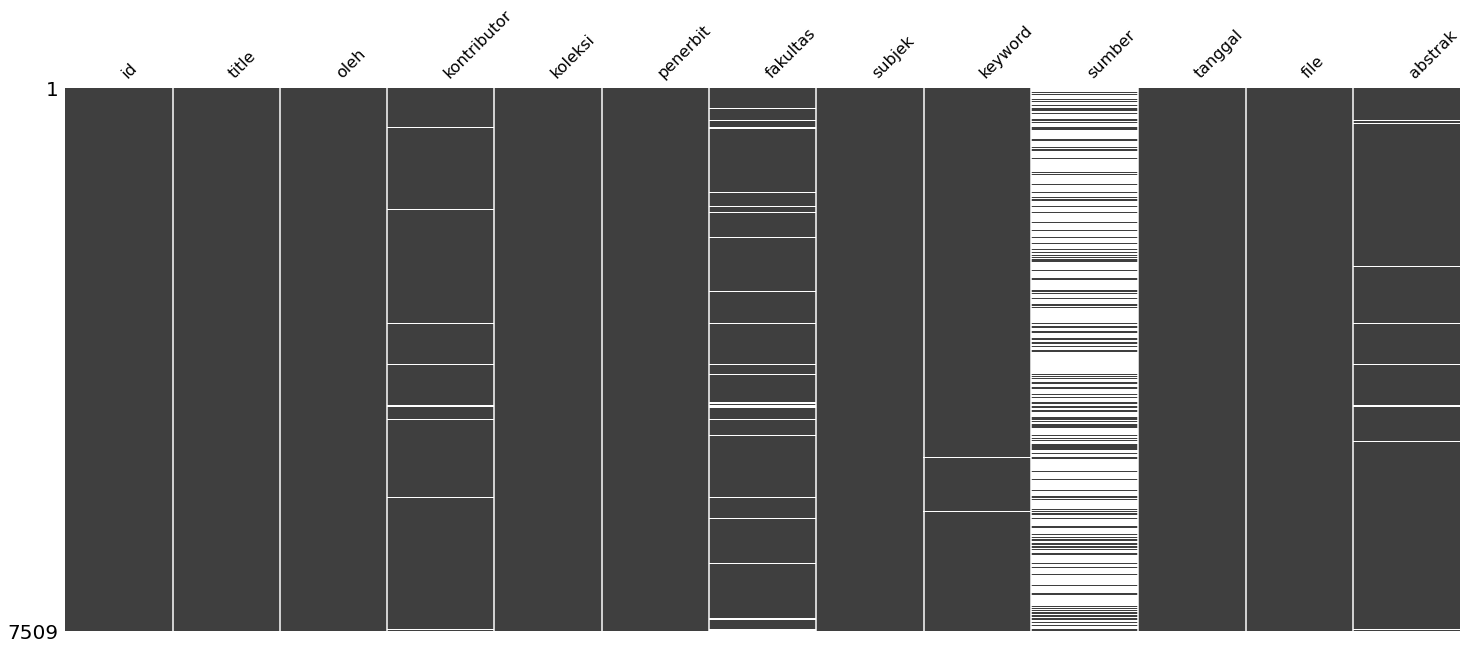

In [23]:
tmp = total[total['subjek']!=''].copy().replace('', np.nan, regex=True)
missingno.matrix(tmp, sparkline=False);

In [24]:
# print(sorted(set(total['subjek'])))

Terlihat keterisian kolom subjek menjadi indikator bagus keterisian kolom-kolom lainnya. Saya memutuskan untuk membiarkannya.

## sumber

Mari kita lihat berapa banyak data unik, dan berapa persen data non-NA kolom ini

In [25]:
len(set(total['sumber'])), 100*len(total[total['sumber']!=''])/len(total)

(2982, 7.730899209141902)

Lebih sedikit, hanya 7.7%. Saya ingin melihat bagaimana sebaran data ini di dataframe, relatif terhadap sebaran data NA kolom-kolom lain.

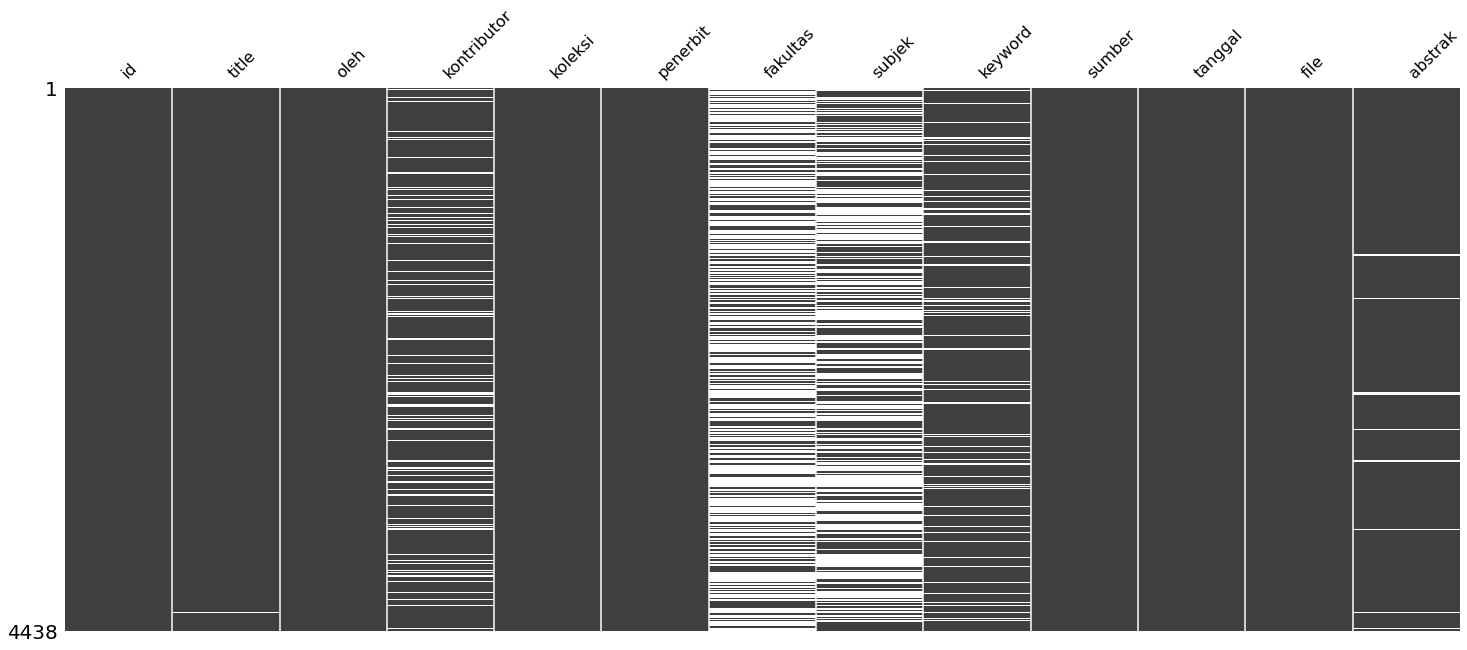

In [26]:
tmp = total[total['sumber']!=''].copy().replace('^.{,3}$', np.nan, regex=True)
missingno.matrix(tmp, sparkline=False);

Terlihat keterisian kolom subjek menjadi indikator bagus keterisian kolom-kolom lainnya. Saya memutuskan untuk membiarkannya.

In [27]:
sorted(set(total['sumber']))[:10]

['',
 '. CURRICULUM STUDIES, 2015 Vol. 47, No. 4, 486–507, http://dx.doi.org/10.1080/00220272.2015.1006685',
 '.TELKOMNIKA; Yogyakarta Vol. 10, Iss. 2, (Jun 2012): 335-342.',
 '.TELKOMNIKA; Yogyakarta Vol. 6, Iss. 1, (Apr 2008): 15-20.',
 '.TELKOMNIKA; Yogyakarta Vol. 7, Iss. 2, (Aug 2009): 83-92.',
 '.TELKOMNIKA; Yogyakarta Vol. 9, Iss. 3, (Dec 2011): 473-482',
 '/ Science of the Total Environment 650 (2019) 1678–1687',
 '1 AUGUST 2019 | VOL 572 | NATURE | 7',
 '1 Faculty of Health, University of Applied Sciences Leiden, Leiden, The Netherlands, 2 Clinical Neurodevelopmental Sciences, Faculty of Social Sciences, Leiden University, Leiden, The Netherlands, 3 KenVak, Research Centre for the Arts Therapies, Heerlen, The Netherlands, 4 Centre for the Arts Therapies, Zuyd University of Applied Sciences, Heerlen, The Netherlands, 5 Faculty of Psychology and Educational Sciences, Open University, Heerlen, The Netherlands',
 '1 JUNE 2017 | VOL 546 | NATURE | 37']

Kita perlu melakukan regex untuk menghilangkan penggunaan spasi ganda.

In [28]:
tmp = total['sumber']
tmp = tmp.apply(multi_space).apply(str.strip)

#sorted(set(tmp))[:100]

Setelah melihat 100 data pertama, saya memutuskan untuk merapikan penulisan nama bulan. Tentu, kedepannya saya ingin dapat merapikan format sitasi jurnal NATURE yang sangat berantakan.

In [29]:
for month in 'NATURE, January, February, March, April, May, June, July, August, September, October, November, December'.upper().split(', '):
    regexed = '( )*'.join(list(month))
    tmp = tmp.apply(lambda x: re.sub(regexed, month, x))

In [30]:
total['sumber'] = tmp

## title, keyword

In [31]:
wordlist = set(total['title'])
print(sorted(set(''.join(wordlist))))

# beberapa pustaka punya judul aestetik... biarkan saja

[' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '©', '®', '°', '±', '¶', '·', 'Â', 'Ã', 'Ä', 'Å', 'Ç', 'È', 'É', 'Í', 'Ï', 'Ñ', 'Ö', '×', 'Ø', 'Þ', 'ß', 'ã', 'ä', 'ç', 'è', 'é', 'í', 'ó', 'ö', 'ü', 'Ō', 'ƒ', 'ơ', '˗', '́', '̈', '̊', '̶', 'Α', 'Β', 'Γ', 'Δ', 'Υ', 'α', 'β', 'γ', 'δ', 'ε', 'κ', 'μ', 'τ', '‐', '–', '—', '‘', '’', '‚', '“', '”', '„', '•', '‰', '⁄', '€', '−', '∙', '∞', '≤']


## oleh
kesalahan yang umum saya lihat disini adalah mengikutkan data nama pembimbing.

In [32]:
# lihat jika ada overlap "kata" (kumpulan karakter yang dipisahkan oleh spasi)
f = lambda a,b: set(a.split()).intersection(set(b.split()))

tmp = total[['oleh', 'kontributor']].apply(lambda x: f(x[0], x[1]), axis=1)

In [33]:
# banyak kata yang overlapping, maksimum 16 kata???
set(tmp.apply(len))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [34]:
for ll in range(10,17):
    print(ll)
    for _,ol,kon in total[['oleh','kontributor']][tmp.apply(len)==ll].to_records():
        print(ol)
        print(kon)
        # break untuk menunjukkan satu kasus saja...
        break
    break

10
SUSANTI ALAWIYAH (NIM 32304004); Pembimbing : Prof. Dr. Ir. Djoko Santoso, M.Sc., Dr. Wawan Gunawan
Pembimbing : Prof. Dr. Ir. Djoko Santoso, M.Sc., Dr. Wawan Gunawan A. Kadir, dan Dr. Darharta Dahrin


In [35]:
from difflib import SequenceMatcher

def cropped(string1, string2):
    a = string1.lower()
    b = string2.lower()
    
    match = SequenceMatcher(None, a, b).find_longest_match(0, len(a), 0, len(b))
    if match.a+match.size==len(a) and match.b==0:
        # string2 terikut di string1
        return string1[:match.a].strip()
    return string1

In [36]:
cropped(ol,kon)

'SUSANTI ALAWIYAH (NIM 32304004);'

In [37]:
total['oleh'] = total[['oleh', 'kontributor']].apply(lambda x: cropped(x[0], x[1]), axis=1)

adanya data nim di kolom oleh tidak harmful untuk use case kita... biarkan saja

## kontributor

data kontributor tercemar dengan format penulisan pembimbing dan ekuivalensinya (supervisor, ketua, ...), dan penulisan gelar yang tidak konsisten -- seringkali menyalahi aturan. Walaupun perapian dapat dilakukan, hal ini akan menyita waktu. Karenanya, saya mengabaikan masalah ini.

## abstrak

Ada banyak kesalahan yang dapat terjadi di kolom ini. Saya memutuskan untuk menghapus sebagian besar dari teks yang menunjukkan data abstrak yang kosong; menghapus teks abstrak `tidak ada abstrak` sebagai contoh.

In [38]:
tmp = total['abstrak'][total['abstrak'].apply(lambda x: len(x) < 100)]

In [39]:
len(set(tmp))

160

In [40]:
# I'm from future cell:

f = lambda x: x if len(x)>24 else ''
g = lambda x: '' if len(x)<50 and 'abstrak' in x.lower() else x

tmp = tmp.apply(f).apply(g)

In [41]:
# tidak semuanya tertangani sih... tapi yaudahlah
# print(tmp)

multi_line = lambda x: re.sub('(\n( )*){2,}', '\n\n', x)

total['abstrak'] = total['abstrak'].apply(f).apply(g).apply(multi_line)

## file

Pada bagian ini, saya ingin menyimpan (dan menunjukkan) data URL file yang dapat diakses oleh publik

In [42]:
tmp = []

for _, i,fs in total[['id', 'file']].to_records():
    for fname, link in fs:
        gid = link.split('/')[-1]
        if gid.isdigit(): gid = int(gid)
        else: gid=-1
        tmp.append({'id':i, 'fname':fname.strip(), 'gid':gid})

tmp = pd.DataFrame(tmp)

In [43]:
gdl = []
for root, _, files in os.walk('collected_file'):
    for file in files:
        try:
            with open(os.sep.join([root, file]), 'rb') as f: gdl.extend(load(f))
        except EOFError:
            pass

gdl = pd.DataFrame(gdl)
gdl['file'] = gdl['file'].apply(lambda x: x.strip())

In [44]:
len(tmp), len(gdl)

(219846, 192252)

In [45]:
merged = tmp.merge(gdl)
merged

,id,fname,gid,file,url
0,22201,2017 TA PP Frans Ambaa 1-ABSTRAK.pdf,113712,2017 TA PP Frans Ambaa 1-ABSTRAK.pdf,https://digilib.itb.ac.id/./assets/./files/dis...
1,22202,2013 TA PP FRANS EDISON 1-COVER.pdf,113713,2013 TA PP FRANS EDISON 1-COVER.pdf,https://digilib.itb.ac.id/./assets/./files/dis...
2,22202,2013 TA PP FRANS EDISON 1-BAB 1.pdf,113714,2013 TA PP FRANS EDISON 1-BAB 1.pdf,https://digilib.itb.ac.id/./assets/./files/dis...
3,22202,2013 TA PP FRANS EDISON 1-BAB 2.pdf,113715,2013 TA PP FRANS EDISON 1-BAB 2.pdf,https://digilib.itb.ac.id/./assets/./files/dis...
4,22202,2013 TA PP FRANS EDISON 1-BAB 3.pdf,113716,2013 TA PP FRANS EDISON 1-BAB 3.pdf,https://digilib.itb.ac.id/./assets/./files/dis...
...,...,...,...,...,...
145733,36492,2019_TS_PP_NADANA_AYZAH_AZIS_1-ABSTRAK.pdf,162383,2019_TS_PP_NADANA_AYZAH_AZIS_1-ABSTRAK.pdf,https://digilib.itb.ac.id/./assets/./files/201...
145734,36494,23215125_abstrak_tesis_indonesia.pdf,162385,23215125_abstrak_tesis_indonesia.pdf,https://digilib.itb.ac.id/./assets/./files/201...
145735,36495,2019_TA_PP_Fazat_Faridah_Alfani_1-ABSTRAK.pdf,162388,2019_TA_PP_Fazat_Faridah_Alfani_1-ABSTRAK.pdf,https://digilib.itb.ac.id/./assets/./files/201...
145736,36497,94516003_-_Nadya.pdf,162386,94516003_-_Nadya.pdf,https://digilib.itb.ac.id/./assets/./files/201...


In [46]:
100*len(merged)/len(gdl)

75.8057133345817

In [47]:
pdf = {}

for _,i,fname,url in merged[['id','fname','url']].to_records():
    if i not in pdf: pdf[i]=[]
    pdf[i].append((fname, url))

In [48]:
z = merged[merged['fname']!=merged['file']]
print(len(z))

zz = z[z['file']!='Database Error']
zz

757


,id,fname,gid,file,url
13796,25280,2018 TA PP AKHMAD ZEIN DWI MUSTOFA 1-ABSTRAK.pdf,126154,AKHMAD ZEIN DWI MUSTOFA - ABSTRAK,https://digilib.itb.ac.id/./assets/./files/dis...
28738,52870,2016_TS_23614010_ARYA_PRIHUTAMA_SUMARJANTO.pdf,220172,2016- ARYA PRIHUTAMA SUMARJANTO,https://digilib.itb.ac.id/./assets/./files/ftm...
61115,31877,2018 TS PP Zaim Sidqi Islami 1-ABSTRAK.pdf,142539,Zaim Sidqi Islami - ABSTRAK.,https://digilib.itb.ac.id/./assets/./files/dis...
143005,52352,2004_TA_13696060_SOFYAN.pdf,220016,2004 - SOFYAN,https://digilib.itb.ac.id/./assets/./files/ftm...


In [49]:
total['pdf'] = total['id'].apply(lambda x: pdf[x] if x in pdf else [])

In [50]:
total['link'] = total['file'].apply(lambda x: x if x else [])
total.drop(columns='file', inplace=True)

## Final

In [51]:
total

,id,title,oleh,kontributor,koleksi,penerbit,fakultas,subjek,keyword,sumber,tanggal,abstrak,pdf,link
0,22201,PERANCANGAN TIPIKAL MATERIAL RECOVERY FACILITY...,Frans Ambaa,"Dr. Benno Rahardyan, S.T., M.T.",Skripsi,,,,"tipikal, MRF, sampah, anorganik, TPA Leuwigajah",,2017-09-27 10:25:22,Timbulan sampah di Indonesia terus meningkat m...,"[(2017 TA PP Frans Ambaa 1-ABSTRAK.pdf, https:...","[(2017 TA PP Frans Ambaa 1-ABSTRAK.pdf, https:..."
1,22202,ESTIMASI STATE OF CHARGE PADA BATERAI VRLA DEN...,FRANS EDISON (NIM : 13307098),"Pembimbing : Dr. Ir. Edi Leksono, M. Eng; Dr. ...",Skripsi,,,,"State of Charge, Coulomb Counting ,Efek Peuker...",,2017-09-27 11:05:11,Baterai mempunyai peran penting dalam perkemba...,"[(2013 TA PP FRANS EDISON 1-COVER.pdf, https:/...","[(2013 TA PP FRANS EDISON 1-COVER.pdf, https:/..."
2,22203,ESTIMASI ENERGI PADA BATERAI NCA DENGAN MEMPER...,Frans Edison (NIM : 23315012),"Dr. Ir. Edi Leksono, M.Eng. Dr. Ir. Nugraha, M...",Tesis,Teknik Fisika,FTI,,"Baterai NCA, Perhitungan Energi, State of Ener...",,2017-10-02 11:23:48,Kendaraan listrik mulai menggantikan kendaraan...,"[(2017 TS PP FRANS EDISON 1-ABSTRAK.pdf, https...","[(2017 TS PP FRANS EDISON 1-ABSTRAK.pdf, https..."
3,22204,ANALISIS DAERAH VULKANIK BERDASARKAN DISTRIBUS...,FRANS FRISCO SAKTI SILABAN (NIM : 10212081),Pembimbing : Dr. Eng. Enjang Jaenal Mustapa,Skripsi,,,,"Inversi 1-Dimensi, Magnetotellurik, Resistivit...",,2017-09-27 11:45:20,Indonesia merupakan Negara yang terdapat diant...,[(2017 TA PP FRANS FRISCO SAKTI SILABAN 1-COVE...,[(2017 TA PP FRANS FRISCO SAKTI SILABAN 1-COVE...
4,22205,PERANCANGAN DETAIL STRUKTUR ATAS MUSEUM SENI R...,FRANSISCA NADIA WIDYARINI [15013012],"Pembimbing : Prof. Ir. Iswandi Imran, MAS. c, ...",Skripsi,Teknik Sipil,FTSL,Civil engineering,"Museum, desain, dinamik, gempa, detail, baja ;",,2017-12-04 20:04:54,Struktur atas Museum Seni Rupa Kontemporer mer...,[(2017 TA PP FRANSISCA NADIA WIDYARINI 1-COVER...,[(2017 TA PP FRANSISCA NADIA WIDYARINI 1-COVER...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57401,36496,PERPUSTAKAAN UMUM DI KOTA YOGYAKARTA LIBRAY AS...,Fenyta Rizky Rahmadhani [15214055],Dr.Ir.Lily Tambunan MT,Skripsi,Arsitektur,SAPPK,Architecture,"Perpustakaan, rekreasi, Interaksi, Urban Oasis...",,2019-03-13 10:32:13,Perpustakaan merupakan salah satu fasilitas pe...,[],[(2019_TA_PP_FENYTA_RIZKY_RAHMADHANI_1-ABSTRAK...
57402,36497,MODEL PENILAIAN KINERJA PERUSAHAAN KAPAL PENGA...,Nadya [94516003],"Dr. Rajesri, S.T., M.T.;",Tesis,Logistik,FTI,,"Freight Forwarder, Penilaian Kinerja, CFA, RII",,2019-03-13 10:32:39,Perkembangan pembangunan dan perbaikan infrast...,"[(94516003_-_Nadya.pdf, https://digilib.itb.ac...","[(94516003_-_Nadya.pdf, https://digilib.itb.ac..."
57403,36498,KAJIAN SENGKETA BATAS WILAYAH INDONESIA MALAYS...,Devi Florenci [15114002],"Dr. Heri Andreas, S.T., M.T.;Dr.techn. Dhota P...",Skripsi,Teknik Geodesi dan Geomatika,FITB,,"Sengketa Batas Negara, Pulau Sebatik, Sungai S...",,2019-03-13 10:39:48,"berupa batas darat, udara maupun batas laut. B...","[(2019_TA_PP_Devi_Florenci_1-ABSTRAK.pdf, http...","[(2019_TA_PP_Devi_Florenci_1-ABSTRAK.pdf, http..."
57404,36499,KAJI ULANG PERENCANAAN JALAN TOL PASIRKOJA – S...,Multi Rizki [15004104],"Prof. Ir. Rudy Hermawan Karsaman, M.Sc., Ph.D....",Skripsi,Teknik Sipil,FTSL,Civil engineering,"jalan tol, perencanaan geometrik, perkerasan kaku",,2019-03-13 10:48:21,Kaji Ulang Perencanaan Jalan Tol Pasirkoja – S...,[],[(2009_TA_PP_MULTI_RIZKI_-_REZKI_DESTRIMAN_1-_...


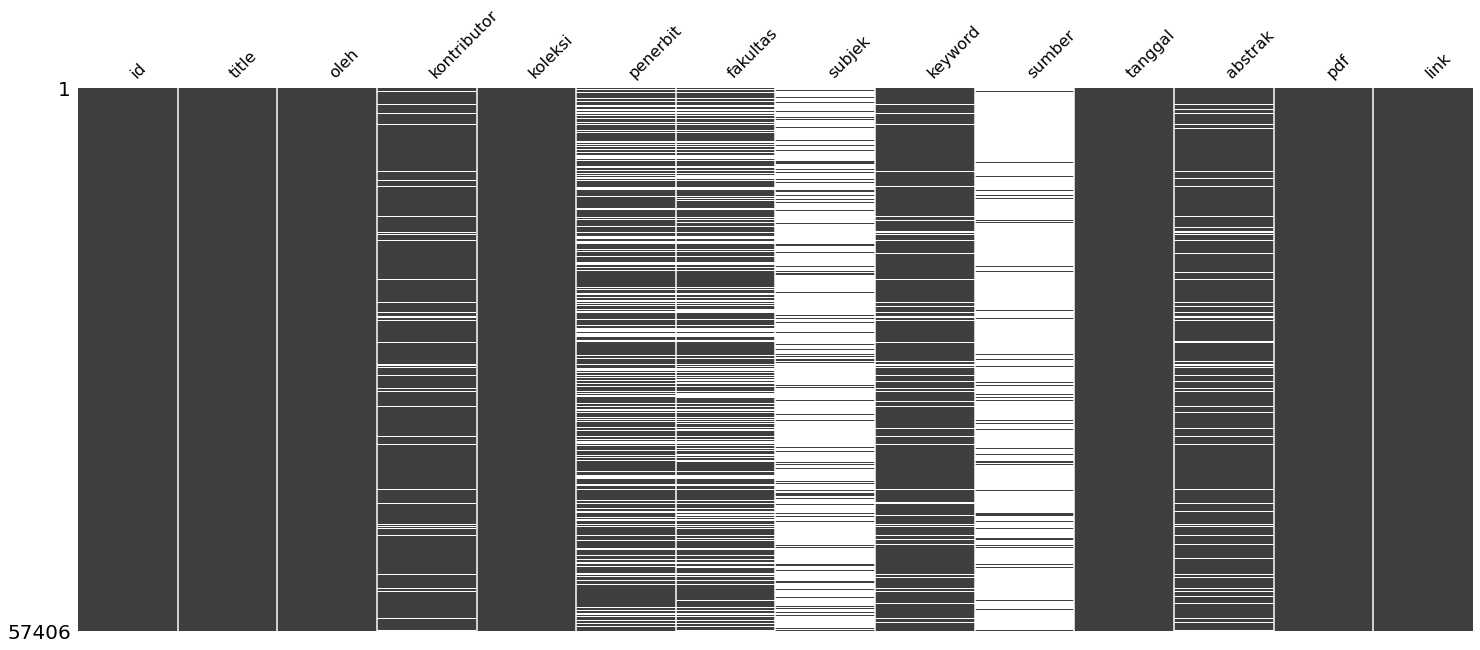

In [52]:
tmp = total.copy()
tmp = tmp.replace('', np.nan, regex=True)

missingno.matrix(tmp, sparkline=False);

In [54]:
total.to_pickle("digilib.pickle")